# Matrix Factorization without and with Bias
## Load user rating file, covert the rating file into user-item matrix

In [1]:
import numpy as np
import pandas as pd

ratingfile = 'ratings.data'
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(ratingfile, sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

user_item_matrix = np.zeros((n_users, n_items))

for line in df.itertuples():
    user_item_matrix[line[1] - 1, line[2] - 1] = line[3]

Number of users = 943 | Number of movies = 1682


## Split the user-item matrix set into training set and testing set

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# split the data set into training set and testing set
train_data, test_data = train_test_split(df, test_size=0.25)

# transfer the train set and test set of ratings to user-item matrix
    
train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

train_matrix = np.zeros((n_users, n_items))
for line in train.itertuples():
    train_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]

test_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]  


## Compute the Rooted mean square error to evaluate the accuaracy

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(pred_rate, true_rate):
    prediction = pred_rate[true_rate.nonzero()].flatten() 
    true_rate = true_rate[true_rate.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, true_rate))

## Get the index for the non-zero rating in training and testing user-item matrix 

In [4]:
# Index matrix for training data
train_ind = train_matrix.copy()
train_ind[train_ind > 0] = 1
train_ind[train_ind == 0] = 0

# Index matrix for test data
test_ind = test_matrix.copy()
test_ind[test_ind > 0] = 1
test_ind[test_ind == 0] = 0

## Prediction function

In [5]:
# Predict the unknown ratings through the dot product of the latent features for users and items and the bias
def prediction_sgd_bias(P, Q, b_global, b_user, b_item):
    ratings = np.dot(P, Q.T)
    for u in range(len(b_user)):
        for i in range(len(b_item)):
            ratings[u][i] = b_global +  b_user[u] + b_item[i] + ratings[u][i]
    return ratings

## Rooted mean square error computation function

In [6]:
# Calculate the RMSE for SGD (without bias)
def sgd_rmse(ind, data_matrix, P, Q):
    return np.sqrt(np.sum((ind * (data_matrix - np.dot(P, Q.T)))**2)/len(data_matrix[data_matrix > 0]))

# Calculate the RMSE for SGD with bias
def sgd_bias_rmse(ind, data_matrix, P, Q, b_global, b_user, b_item):
    return np.sqrt(np.sum((ind * (data_matrix - prediction_sgd_bias(P, Q, b_global, b_user, b_item)))**2)/len(data_matrix[data_matrix > 0]))

## Stochastic Gradient Descent (SGD) function

In [7]:
def sgd(train, test, train_ind, test_ind, factor_k, alpha, lmbda, iteration):
    print ("Computing using SGD ......")
    
    train_errors = []
    test_errors = []
    
    m, n = train.shape # Number of users and items in training set
    
    # initialize Latent user feature matrix and Latent movie feature matrix
    P = 3 * np.random.rand(m, factor_k)  # Latent user feature matrix
    Q = 3 * np.random.rand(n, factor_k)  # Latent movie feature matrix
    
    # Only consider non-zero elements in the training matrix
    users, items = train.nonzero()
    for it in range(iteration):
        print("SGD Iteration", it)
        for u, i in zip(users, items):
            e = train[u, i] - (np.dot(P[u], Q[i].T))  # Calculate error for gradient
            P[u] += alpha * (e * Q[i] - lmbda * P[u])  # Update latent user feature matrix
            Q[i] += alpha * (e * P[u] - lmbda * Q[i])  # Update latent movie feature matrix
        train_rmse = sgd_rmse(train_ind, train, P, Q)  # Calculate root mean squared error from train dataset
        test_rmse = sgd_rmse(test_ind, test, P, Q)  # Calculate root mean squared error from test dataset
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)

    return train_errors, test_errors

## Prediction using SGD
** It is important to note that SGD with 100 iterations may take more than 10 minutes or more to complete! (depend on your computer) **

In [8]:
factor_k = 20 # number of latent features
alpha = 0.0001 # Learning rate
lmbda = 0.1 # Regularisation weight
iteration = 100 # number of iteration
# use stochastic gradient descent to optimize the predictionS
train_errors_sgd, test_errors_sgd = sgd(train_matrix, test_matrix, train_ind, test_ind, factor_k, alpha, lmbda, iteration)

Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 

In [9]:
print(test_errors_sgd[90:100])

[2.709082769358688, 2.6984328805841122, 2.6879050795262263, 2.67749606090397, 2.667202663880669, 2.657021865369199, 2.6469507737015316, 2.636986622636845, 2.6271267656844475, 2.617368670719647]


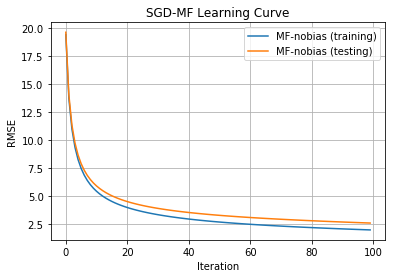

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Check performance by plotting train and test errors
plt.plot(range(100), train_errors_sgd, linestyle='-', label='MF-nobias (training)')
plt.plot(range(100), test_errors_sgd, linestyle='-', label='MF-nobias (testing)')
plt.title('SGD-MF Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Matrix Factoriztion with Bias (SGD)

In [11]:
def sgd_bias(train, test, train_ind, test_ind, factor_k, alpha, lmbda, iteration):
    print ("Computing using SGD ......")
    
    train_errors = []
    test_errors = []
    # your code needs to be added here for MF with bias by SGD
    
    m, n = train.shape # Number of users and items in training set
    
    # initialize Latent user feature matrix and Latent movie feature matrix
    P = 3 * np.random.rand(m, factor_k)  # Latent user feature matrix
    Q = 3 * np.random.rand(n, factor_k)  # Latent movie feature matrix
    M = np.mean(train[np.where(train!=0)]) # compute the mean of nonzero value
    bu= 3 * np.random.rand(m)   # Latent user bias matrix
    bi= 3 * np.random.rand(n)   # Latent movie bias matrix
    
    # Only consider non-zero elements in the training matrix
    users, items = train.nonzero()
    for it in range(iteration):
        print("SGD Iteration", it)
        for u, i in zip(users, items):
            e = train[u, i] - (np.dot(P[u], Q[i].T)+M+bu[u]+bi[i])  # Calculate error for gradient
            P[u] += alpha * (e * Q[i] - lmbda * P[u])  # Update latent user feature matrix
            Q[i] += alpha * (e * P[u] - lmbda * Q[i])  # Update latent movie feature matrix
            M+=alpha * (e - lmbda * M) # Update laten mu
            bu[u]+= alpha * (e - lmbda *bu[u]) # Update latent user bias matrix
            bi[i]+= alpha * (e - lmbda *bi[i]) # Update latent movie bias matrix
            
        train_rmse = sgd_bias_rmse(train_ind, train, P, Q, M, bu, bi)  # Calculate root mean squared error from train dataset
        test_rmse = sgd_bias_rmse(test_ind, test, P, Q,M, bu, bi)  # Calculate root mean squared error from test dataset
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
  
    return train_errors, test_errors


## Rating Prediction using Stochatic Gradient Descent with Bias

In [12]:
factor_k = 20 # number of latent features
alpha = 0.0001 # Learning rate
lmbda = 0.1 # Regularization weight
iteration = 100 # number of iteration
# use stochastic gradient descent to optimize the prediction

train_errors_sgd_bias, test_errors_sgd_bias = sgd_bias(train_matrix, test_matrix, train_ind, test_ind, factor_k, alpha, lmbda, iteration)

Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 

In [13]:
print(test_errors_sgd_bias)#[90:100])

[8.232987771119207, 6.2886661689250545, 5.675626161789596, 5.387211229803671, 5.218594366306867, 5.10278943500652, 5.013098170731241, 4.937440983783271, 4.869836027504773, 4.807130687701921, 4.747595777683213, 4.690261685138118, 4.634580693102815, 4.5802451737779375, 4.527085565584118, 4.475011475248358, 4.423977083438173, 4.373960674075604, 4.324952549314041, 4.276947991288856, 4.229943281011766, 4.1839335684115495, 4.138911854211439, 4.094868627629647, 4.0517918783021, 4.00966730926059, 3.968478645616767, 3.9282079761125646, 3.8888360913006115, 3.8503427986660936, 3.812707205173349, 3.7759079638488404, 3.7399234845865674, 3.704732111328854, 3.670312268751978, 3.636642581952933, 3.603701972647895, 3.571469735205295, 3.5399255955488846, 3.5090497556375824, 3.47882292589395, 3.4492263476361367, 3.420241807273791, 3.3918516437670796, 3.3640387506164164, 3.3367865734496984, 3.310079104100668, 3.2839008719243385, 3.258236932969169, 3.2330728575195433, 3.2083947164322257, 3.1841890666150716

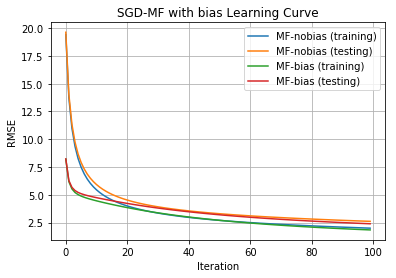

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
#Draw the graph
plt.plot(range(100), train_errors_sgd, linestyle='-',  label='MF-nobias (training)')
plt.plot(range(100), test_errors_sgd, linestyle='-', label='MF-nobias (testing)')
plt.plot(range(100), train_errors_sgd_bias, linestyle='-',  label='MF-bias (training)')
plt.plot(range(100), test_errors_sgd_bias, linestyle='-', label='MF-bias (testing)')

plt.title('SGD-MF with bias Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [15]:
train_errors_sgd_list = []
test_errors_sgd_list = []
train_errors_sgd_bias_list = []
test_errors_sgd_bias_list = []

#varying the number of latent factors
for i in range(1,21):
    k = i * 5
    train_errors_sgd, test_errors_sgd = sgd(train_matrix, test_matrix, train_ind, test_ind, k, alpha, lmbda, iteration)
    train_errors_sgd_list.append(train_errors_sgd[-1]) #choose the last value 
    test_errors_sgd_list.append(test_errors_sgd[-1]) #choose the last value 
    train_errors_sgd_bias, test_errors_sgd_bias = sgd_bias(train_matrix, test_matrix, train_ind, test_ind, k, alpha, lmbda, iteration)
    train_errors_sgd_bias_list.append(train_errors_sgd_bias[-1]) #choose the last value 
    test_errors_sgd_bias_list.append(test_errors_sgd_bias[-1]) #choose the last value 
    

Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 

SGD Iteration 77
SGD Iteration 78
SGD Iteration 79
SGD Iteration 80
SGD Iteration 81
SGD Iteration 82
SGD Iteration 83
SGD Iteration 84
SGD Iteration 85
SGD Iteration 86
SGD Iteration 87
SGD Iteration 88
SGD Iteration 89
SGD Iteration 90
SGD Iteration 91
SGD Iteration 92
SGD Iteration 93
SGD Iteration 94
SGD Iteration 95
SGD Iteration 96
SGD Iteration 97
SGD Iteration 98
SGD Iteration 99
Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 

SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration 58
SGD Iteration 59
SGD Iteration 60
SGD Iteration 61
SGD Iteration 62
SGD Iteration 63
SGD Iteration 64
SGD Iteration 65
SGD Iteration 66
SGD Iteration 67
SGD Iteration 68
SGD Iteration 69
SGD Iteration 70
SGD Iteration 71
SGD Iteration 72
SGD Iteration 73
SGD Iteration 74
SGD Iteration 75
SGD Iteration 76
SGD Iteration 77
SGD Iteration 78
SGD Iteration 79
SGD Iteration 80
SGD Iteration 81
SGD Iteration 82
SGD Iteration 83
SGD Iteration 84
SGD Iteration 85
SGD Iteration 86
SGD Iteration 87
SGD Iteration 88
SGD Iteration 89
SGD Iteration 90
SGD Iteration 91
SGD Iteration 92
SGD Iteration 93
SGD Iteration 94
SGD Iteration 95
SGD Iteration 96
SGD Iteration 97
SGD Iteration 98
SGD Iteration 99
Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 

SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration 58
SGD Iteration 59
SGD Iteration 60
SGD Iteration 61
SGD Iteration 62
SGD Iteration 63
SGD Iteration 64
SGD Iteration 65
SGD Iteration 66
SGD Iteration 67
SGD Iteration 68
SGD Iteration 69
SGD Iteration 70
SGD Iteration 71
SGD Iteration 72
SGD Iteration 73
SGD Iteration 74
SGD Iteration 75
SGD Iteration 76
SGD Iteration 77
SGD Iteration 78
SGD Iteration 79
SGD Iteration 80
SGD Iteration 81
SGD Iteration 82
SGD Iteration 83
SGD Iteration 84
SGD Iteration 85
SGD Iteration 86
SGD Iteration 87
SGD Iteration 88
SGD Iteration 

SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration 58
SGD Iteration 59
SGD Iteration 60
SGD Iteration 61
SGD Iteration 62
SGD Iteration 63
SGD Iteration 64
SGD Iteration 65
SGD Iteration 66

SGD Iteration 87
SGD Iteration 88
SGD Iteration 89
SGD Iteration 90
SGD Iteration 91
SGD Iteration 92
SGD Iteration 93
SGD Iteration 94
SGD Iteration 95
SGD Iteration 96
SGD Iteration 97
SGD Iteration 98
SGD Iteration 99
Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 

SGD Iteration 64
SGD Iteration 65
SGD Iteration 66
SGD Iteration 67
SGD Iteration 68
SGD Iteration 69
SGD Iteration 70
SGD Iteration 71
SGD Iteration 72
SGD Iteration 73
SGD Iteration 74
SGD Iteration 75
SGD Iteration 76
SGD Iteration 77
SGD Iteration 78
SGD Iteration 79
SGD Iteration 80
SGD Iteration 81
SGD Iteration 82
SGD Iteration 83
SGD Iteration 84
SGD Iteration 85
SGD Iteration 86
SGD Iteration 87
SGD Iteration 88
SGD Iteration 89
SGD Iteration 90
SGD Iteration 91
SGD Iteration 92
SGD Iteration 93
SGD Iteration 94
SGD Iteration 95
SGD Iteration 96
SGD Iteration 97
SGD Iteration 98
SGD Iteration 99
Computing using SGD ......
SGD Iteration 0
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 

SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration 58
SGD Iteration 59
SGD Iteration 60
SGD Iteration 61
SGD Iteration 62
SGD Iteration 63
SGD Iteration 64
SGD Iteration 65
SGD Iteration 66
SGD Iteration 67
SGD Iteration 68
SGD Iteration 69
SGD Iteration 70
SGD Iteration 71
SGD Iteration 72
SGD Iteration 73
SGD Iteration 74
SGD Iteration 75
SGD Iteration 76
SGD Iteration 77
SGD Iteration 78
SGD Iteration 79
SGD Iteration 80
SGD Iteration 81
SGD Iteration 82
SGD Iteration 83
SGD Iteration 84
SGD Iteration 85
SGD Iteration 86
SGD Iteration 87
SGD Iteration 88
SGD Iteration 89
SGD Iteration 90
SGD Iteration 91
SGD Iteration 92
SGD Iteration 93
SGD Iteration 94
SGD Iteration 95
SGD Iteration 96
SGD Iteration 97
SGD Iteration 98
SGD Iteration 

SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration 58
SGD Iteration 59
SGD Iteration 60
SGD Iteration 61
SGD Iteration 62
SGD Iteration 63
SGD Iteration 64
SGD Iteration 65
SGD Iteration 66
SGD Iteration 67
SGD Iteration 68
SGD Iteration 69
SGD Iteration 70
SGD Iteration 71
SGD Iteration 72
SGD Iteration 73
SGD Iteration 74
SGD Iteration 75
SGD Iteration 

In [16]:
print(train_errors_sgd_list)
print(test_errors_sgd_list)
print(train_errors_sgd_bias_list)
print(test_errors_sgd_bias_list)

[1.3020457083472838, 1.6320186819004865, 1.8888170952571248, 2.057279148188678, 2.1155458552868973, 2.1894319863736635, 2.211533720612363, 2.205817205576547, 2.1458794606413445, 2.1680488794076225, 2.1431128788742857, 2.1806497395467894, 2.0960005012553413, 2.0811064491729563, 2.0852605341446044, 2.0372465429427242, 2.0102861398949528, 1.992637911966385, 1.952260055555016, 1.9597899788381117]
[1.4089799710292774, 1.8601475090303556, 2.32169610744117, 2.660790989113156, 2.9898475570827467, 3.330699956162516, 3.622318448205145, 3.8928800282298885, 4.149323355673908, 4.556753978328923, 4.845267512065487, 5.128475336442305, 5.434114605492136, 5.818528925074223, 6.005377536997078, 6.358505759475864, 6.615137082258652, 7.074851523911747, 7.419398601188419, 7.841972692304054]
[1.3087911641397423, 1.5795302722147426, 1.7525978842261984, 1.8430327126706652, 1.89475075153364, 1.9149492801709422, 1.8980085931960384, 1.9043677528662777, 1.895477550208016, 1.8634861190817074, 1.8693565383690085, 1.

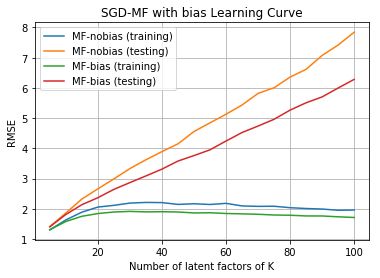

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#Draw the graph
x=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

plt.plot(x,train_errors_sgd_list,label='MF-nobias (training)')
plt.plot(x,test_errors_sgd_list,label='MF-nobias (testing)')
plt.plot(x,train_errors_sgd_bias_list,label='MF-bias (training)')
plt.plot(x,test_errors_sgd_bias_list,label='MF-bias (testing)')

plt.title('SGD-MF with bias Learning Curve')
plt.xlabel('Number of latent factors of K')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
#備註:alpha值0.01及0.0001畫出來結果均不理想，因為時間關係還未找到較好的alpha值


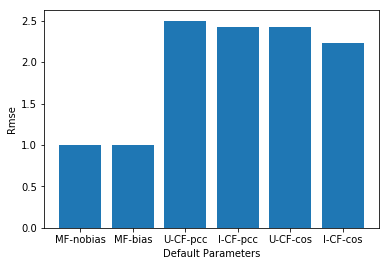

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
#k=20
x=[1,2,3,4,5,6]
number=[1,1,2.5,2.43,2.43,2.23] #from the graph
label=['MF-nobias','MF-bias','U-CF-pcc','I-CF-pcc','U-CF-cos','I-CF-cos']
plt.xlabel('Default Parameters')
plt.ylabel('Rmse')
plt.bar(x,number)
plt.xticks(x,label)
plt.show()